<a href="https://colab.research.google.com/github/rinkideo/datascience_projects/blob/master/plant_seedling_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section

In [ ]:
!pip install kaggle

In [ ]:
## Uploading the Credentials of Kaggle Account
from google.colab import files
files.upload()

In [ ]:

"""'
DOWNLOAD THE KAGGLE.JSON FILE
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. 
This will trigger the download of kaggle.json, a file containing your API credentials. 
Place this file in the location ~/.kaggle/kaggle.json (on Windows in the location in the location C:\Users\<Windows-username>\
"""
## make a directory  .kaggle (in the location C:\Users\<Windows-username>\.kaggle) and move or copy the downloaded kaggle.json file in this directoryin the location
## C:\Users\<Windows-username>\kaggle.json


In [ ]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
##Import the required dataset for the project from Kaggle
## !kaggle competitions download -c plant-seedlings-classification

You can increase the memory allocation to ~25.51 GB RAM and GPU to ~ 16 GB by running the following command.
d=[]
while(1):
  d.append('1')
   You can then check the GPU allocated by running the following command.
!nvidia-smi

In [11]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [12]:
import zipfile as zf
seedling_data_zip = zf.ZipFile('/content/drive/My Drive/Colab Notebooks/plant-seedlings-classification.zip')
seedling_data_zip.extractall()
!ls

drive  sample_data  sample_submission.csv  test  train


In [13]:
train_data_path = '/content/train'
test_data_path  =  '/content/test'

In [3]:
 import os
 os.listdir(train_data_path)

NameError: ignored

In [15]:
import os,sys
from glob import glob
import cv2
images = []
class_label = []
for class_folder_name in os.listdir(train_data_path):
    class_folder_path = os.path.join(train_data_path, class_folder_name)
    class_name = class_folder_name
    
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images.append(image_rgb)
        class_label.append(class_name)

In [16]:
len(images)

4750

**Distribution of each class**


In [17]:
from collections import Counter
images_per_class = dict(Counter(class_label))

In [18]:
images_per_class

{'Black-grass': 263,
 'Charlock': 390,
 'Cleavers': 287,
 'Common Chickweed': 611,
 'Common wheat': 221,
 'Fat Hen': 475,
 'Loose Silky-bent': 654,
 'Maize': 221,
 'Scentless Mayweed': 516,
 'Shepherds Purse': 231,
 'Small-flowered Cranesbill': 496,
 'Sugar beet': 385}

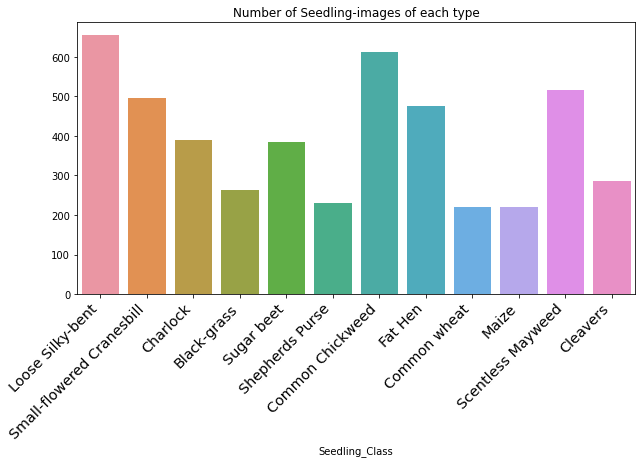

In [19]:
plt.figure(figsize=(10,5))
class_plot = sns.barplot(x = list(images_per_class.keys()), y = list(images_per_class.values()))
plt.title("Number of Seedling-images of each type")

plt.xlabel("Seedling_Class")
class_plot.set_xticklabels(class_plot.get_xticklabels(), 
                           rotation=45,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show(class_plot)


## Resizing images
#### Original Size


In [20]:
##original dimension of a image
dim= images[0].shape

print("dimension {}".format(dim))

width = images[0].shape[1]
height = images[0].shape[0]
bands = images[0].shape[2]

print("width {}".format(width))
print("height {}".format(height))
print("bands {}".format(bands))


dimension (367, 367, 3)
width 367
height 367
bands 3


In [21]:
###Function for resizing(256 by 256) the image
def resize_images(img):

  #img = np.array(img).astype(np.uint8)
  
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

### Resize all the images to the dimension 256 by 256

In [22]:
#save resized images into images.
images_rsz = [resize_images(img) for img in images]
images_rsz[0].shape

(256, 256, 3)

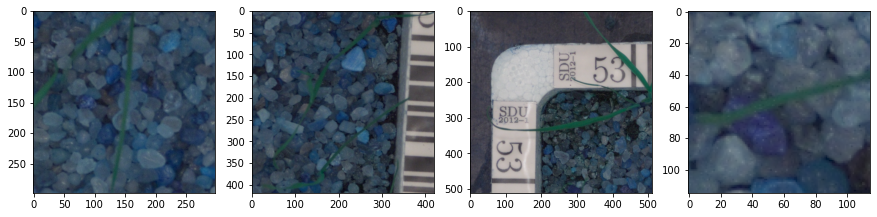

In [23]:
## Before resizing
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(images[10])
axs[1].imshow(images[11])
axs[2].imshow(images[22])
axs[3].imshow(images[35])

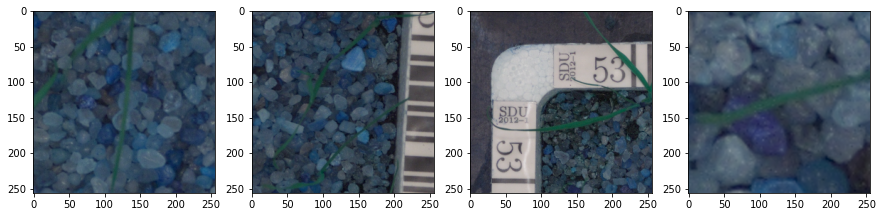

In [27]:
## After resizing
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(images_rsz[10])
axs[1].imshow(images_rsz[11])
axs[2].imshow(images_rsz[22])
axs[3].imshow(images_rsz[35])

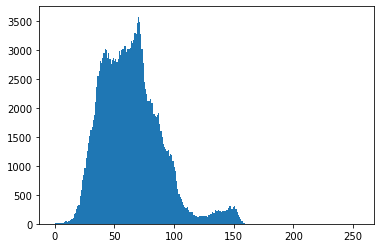

In [31]:

plt.hist(images_rsz[480].ravel(),256,[0,255])
plt.show()

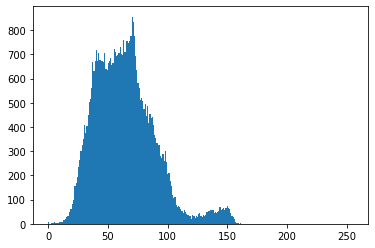

In [39]:
plt.hist(images[480].ravel(),256,[0,255])
plt.show()

## Image *Processing*

### Defining function for image segmenting and then sharpening


In [36]:
### Function for creating mask
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask
### Function for segmenting the plant in the image
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

#### Function for sharpening the segmented image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [37]:
##Combine above three function in one function
def segment_sharpen(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

#### Segmenting and sharpening each of the images


In [38]:
images_proc=images_rsz.copy()

for indx, image in enumerate(images_proc):
    images_proc[indx] = segment_sharpen(image)

### Displaying a sample to see the effect of segmenting and sharpening

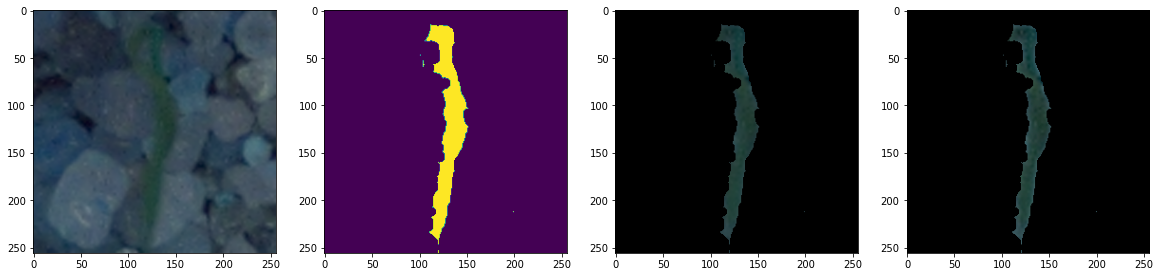

In [41]:
## Let us see a sample resized_image for each step #creating mask, segmenting and sharpening

image= images_rsz[482]
image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)

axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [43]:
### Convert the 1d list of 3 band images to an array of 4d
images_fin = np.array(images_proc)
classes_fin =np.array(class_label)

In [44]:
images_fin.shape
### 4750 images, 256 width, 256 height, and three bands

(4750, 256, 256, 3)

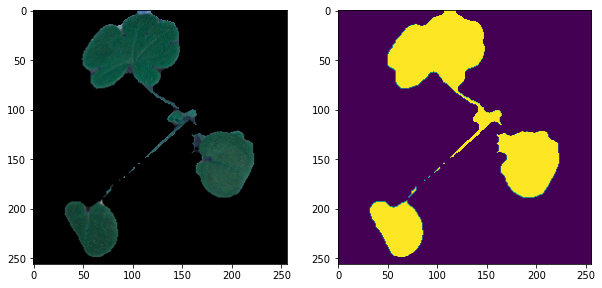

In [46]:
image = images_fin[classes_fin == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image)
axs[1].imshow(image_mask)


## Data Preparation for modeling
Preparing the target variable: It will have 4750 rows and 12 columns(corresponding to each class)

In [50]:
#### Encoding the classes
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes_fin)


In [51]:
y.shape

(4750, 12)

**Splitting the data(input variables) to train and test**

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_fin, y, test_size=0.3, random_state=50)

In [53]:
X_train.shape

(3325, 256, 256, 3)

In [54]:
X_test.shape

(1425, 256, 256, 3)

Split test data into 50% test, 50% validation

In [59]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [60]:

print(X_test.shape)
print(X_val.shape)

(712, 256, 256, 3)
(713, 256, 256, 3)


# MODELING

Now the data is fully prepared to be used in modelling. The defined probelm is: predicting seedling class from its image.

Solution: As a solution of this prediction we will 

1) design a CNN model and

2) Transfer Learning: Use different available trained NN models 



## CNN Model Architecture

In [1]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)       

In [2]:
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
model.fit(X_train, y_train, epochs = 50,validation_data = (X_val,Y_val),batch_size = batch_size)

Train on 3325 samples, validate on 713 samples
Epoch 1/50
3325/3325 [==============================] - 46s 14ms/step - loss: 1.7539 - accuracy: 0.3783 - val_loss: 1.7112 - val_accuracy: 0.4614
Epoch 2/50
3325/3325 [==============================] - 45s 14ms/step - loss: 1.6136 - accuracy: 0.4241 - val_loss: 1.5590 - val_accuracy: 0.5596
Epoch 3/50
3325/3325 [==============================] - 46s 14ms/step - loss: 1.5051 - accuracy: 0.4812 - val_loss: 1.4320 - val_accuracy: 0.5694
Epoch 4/50
3325/3325 [==============================] - 46s 14ms/step - loss: 1.4209 - accuracy: 0.5083 - val_loss: 1.3315 - val_accuracy: 0.5792
Epoch 5/50
3325/3325 [==============================] - 46s 14ms/step - loss: 1.3078 - accuracy: 0.5519 - val_loss: 1.3083 - val_accuracy: 0.5540
Epoch 6/50
3325/3325 [==============================] - 45s 14ms/step - loss: 1.2027 - accuracy: 0.5967 - val_loss: 1.2215 - val_accuracy: 0.5806
Epoch 7/50
3325/3325 [==============================] - 45s 14ms/step - loss:

In [ ]:

score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Data Augmentation

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
X_train, X_test, y_train, y_test
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:

score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Model Evaluation

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion Matrix

In [ ]:
rom sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))